## This code uses the metropolis algorithm to sample from the posterior distribution using a nonlinear sine function as the simulator

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal

In [2]:
import numpy as np

def Metropolis_Algorithm(f, data, prior_F, theta0, noise_var, M, covar, UB, LB):
    """
    Implements the Metropolis algorithm to generate a Markov chain for parameter estimation.

    Parameters:
    f: function - Model function.
    data: array - Observed data.
    prior_F: function - Prior probability distribution.
    theta0: array - Initial parameter values.
    noise_var: float - Variance of measurement noise.
    M: int - Number of samples in the Markov chain.
    covar: array - Covariance matrix for proposal distribution.
    UB: array - Upper bounds for parameters.
    LB: array - Lower bounds for parameters.

    Returns:
    chain: array - Markov chain of sampled parameters.
    """

    n_par = len(theta0)
    chain = np.zeros((n_par, M))
    n_y = len(data)
    
    if covar is None:
        covar = np.eye(n_par) * 0.1 * np.abs(theta0)
    
    # Likelihood function
    def lik_func(param, data):
        residual = f(param) - data
        return np.exp(-np.sum(residual**2) / (2 * noise_var)) * (2 * np.pi * noise_var)**(-n_y / 2)
    
    chain[:, 0] = theta0
    lik_old = lik_func(theta0, data)
    prior_old = prior_F(theta0)
    R = np.linalg.cholesky(covar)
    num_acc = 0
    
    prob_acc = np.random.uniform(0, 1, M)
    
    for i in range(1, M):
        theta_star = chain[:, i - 1] + np.dot(R, np.random.normal(0, 1, n_par))
        
        # Check bounds
        if np.any(theta_star > UB) or np.any(theta_star < LB):
            lik_star = -np.inf
        else:
            lik_star = lik_func(theta_star, data)
        
        prior_star = prior_F(theta_star)
        
        acc_prob = (prior_star * lik_star) / (prior_old * lik_old)
        if acc_prob > prob_acc[i]:
            chain[:, i] = theta_star
            lik_old = lik_star
            prior_old = prior_star
            num_acc += 1
        else:
            chain[:, i] = chain[:, i - 1]
    
    print('Acceptance rate:', (num_acc / M) * 100)
    
    return chain

In [46]:
# Define the Sine model
def sin_model(q, x):
    return q[0]*q[1] * np.sin(np.pi * q[2] * x)

# Parameters
xspace = np.linspace(-5, 5, 20)
param_star = np.array([5, 1, 0.3])
num_param = 3
n_xpts = len(xspace)

# Adjustable variables
prior_mu = param_star * 1.0
prior_var = param_star * 0.5
noise_var = 0.2

covar = np.eye(num_param) * 0.005 * np.abs(param_star)

# Uniform bounds
UB_uni = np.array([10, 4, 1])
LB_uni = np.array([1, 0.1, 0.01])
UB_gauss = prior_mu + 3 * np.sqrt(prior_var)
LB_gauss = prior_mu - 3 * np.sqrt(prior_var)

In [47]:
# Define priors
def prior_unif(param, a, b):
    return 1 / np.prod(b - a)

def prior_gauss(param, mu, covar):
    diff = param - mu
    return np.exp(-0.5 * np.dot(diff.T, np.linalg.inv(covar).dot(diff))) / np.sqrt((2 * np.pi)**len(mu) * np.linalg.det(covar))

# Generate data
f_mod = lambda param: sin_model(param, xspace)
true_signal = f_mod(param_star)
data = true_signal + np.random.normal(0, np.sqrt(noise_var), n_xpts)

In [51]:
# Uniform prior
prior_F = lambda param: prior_unif(param, LB_uni, UB_uni)
theta0 = param_star*1.0
M = 50000
chain_uni = Metropolis_Algorithm(f_mod, data, prior_F, theta0, noise_var, M, covar, UB_uni, LB_uni)



Acceptance rate: 4.8


In [52]:
# Gaussian prior
prior_F = lambda param: prior_gauss(param, prior_mu, covar)
chain_gauss = Metropolis_Algorithm(f_mod, data, prior_F, theta0, noise_var, M, covar, UB_gauss, LB_gauss)

Acceptance rate: 4.188


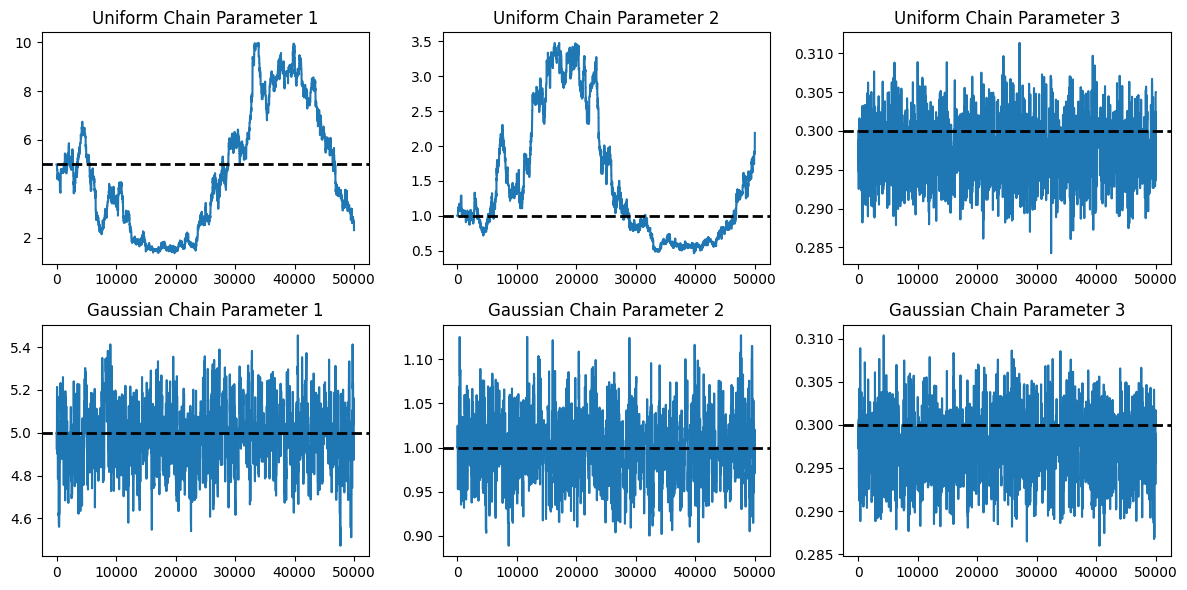

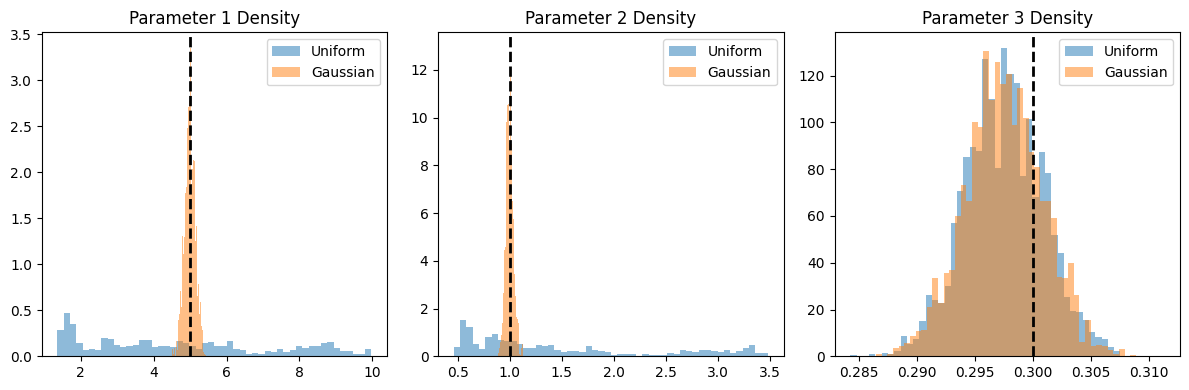

In [53]:

# Plot results
plt.figure(figsize=(12, 6))
for i in range(3):
    plt.subplot(2, 3, i + 1)
    plt.plot(chain_uni[i, :])
    plt.axhline(param_star[i], color='k', linestyle='--', linewidth=2)
    plt.title(f'Uniform Chain Parameter {i+1}')
    
    plt.subplot(2, 3, i + 4)
    plt.plot(chain_gauss[i, :])
    plt.axhline(param_star[i], color='k', linestyle='--', linewidth=2)
    plt.title(f'Gaussian Chain Parameter {i+1}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.hist(chain_uni[i, :], bins=50, density=True, alpha=0.5, label="Uniform")
    plt.hist(chain_gauss[i, :], bins=50, density=True, alpha=0.5, label="Gaussian")
    plt.axvline(param_star[i], color='k', linestyle='--', linewidth=2)
    plt.title(f'Parameter {i+1} Density')
    plt.legend()
plt.tight_layout()
plt.show()

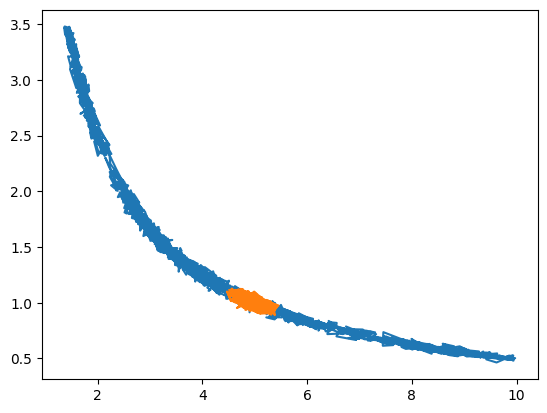

In [55]:
plt.figure()
plt.plot(chain_uni[0, :],chain_uni[1, :])
plt.plot(chain_gauss[0, :],chain_gauss[1, :])
plt.show()